In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm

In [3]:
dataloader = utils.MRIDataLoader()

In [4]:
id = 2
slice_default = 25
vox_i = 50
vox_j = 45
mri_data = dataloader.get_img(id, 'signal')
mask_data = dataloader.get_img(id, 'mask')
TE_times = dataloader.get_TE_times()
thresh_default = 0.9

In [5]:
problem_one_compartment = utils.create_problem_to_minimize('one_compartment')
problem_two_compartment = utils.create_problem_to_minimize('two_compartment')
problem_two_v_compartment = utils.create_problem_to_minimize('two_compartment_v')

In [8]:
# true_signal = mri_data[vox_i, vox_j, slice_default,:]

# Define the objective function
# def objective_fixed(x, signal, TE_times):
#     S0, T2 = x
#     S0, T2 = np.array([S0]), np.array([T2])
#     vox_est = utils.model_one_compartment(T2, S0, TE_times)
#     rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
#     return rmse

def objective_one_compartment(x, signal, TE_times):
    S0, T2 = x
    vox_est = utils.model_one_compartment_voxel(T2, S0, TE_times)
    rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
    return rmse

# Define the constraint function
def constraint_one_compartment(x):
    return 0

# Define the bounds of the variables
bounds = [(0, None), (0, None)]
problem_one_compartment = {'fun': objective_one_compartment, 'bounds': bounds}

# Set the initial guess for the variables
x0 = [4000, 1]

# Define the optimization problem
# problem = {'fun': objective, 'constraints': [{'type': 'eq', 'fun': constraint}], 'bounds': bounds}


X_1 = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], 2))
rmse_1 = np.zeros(shape=mri_data.shape[:2])

for vox_i in tqdm(range(mri_data.shape[0])):
    for vox_j in range(mri_data.shape[0]):
        if mask_data[vox_i, vox_j, slice_default] > thresh_default:
            vox_signal = mri_data[vox_i, vox_j, slice_default, :]
            solution = minimize(**problem_one_compartment, x0=x0, args=(vox_signal, TE_times), method='L-BFGS-B')
            S0, T2 = solution['x'][0], solution['x'][1]
            X_1[vox_i, vox_j, 0] = S0
            X_1[vox_i, vox_j, 1] = T2
            vox_est = utils.model_one_compartment_voxel(T2, S0, TE_times)
            rmse_1[vox_i, vox_j] = utils.RMSE(signal_actual=vox_signal, signal_estimate=vox_est)


 26%|██▌       | 25/96 [00:00<00:00, 12610.66it/s]


AxisError: axis 1 is out of bounds for array of dimension 1

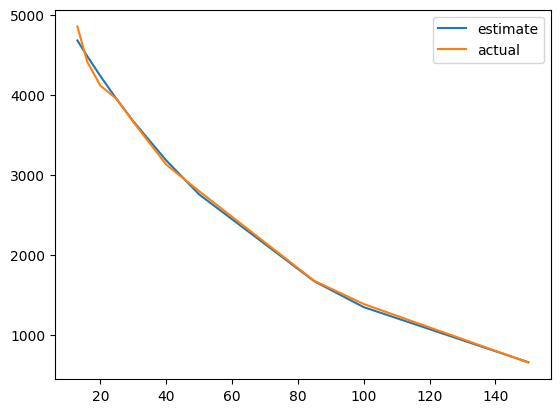

In [ ]:
vox_i, vox_j = 60, 50
S0, T2 = X_1[vox_i, vox_j]
true_signal = mri_data[vox_i, vox_j, slice_default,:]
vox_est = utils.model_one_compartment_voxel(T2, S0, TE_times)

plt.plot(TE_times, vox_est, label='estimate')
plt.plot(TE_times, true_signal, label='actual')
plt.legend()
plt.show()

### Now lets fit a 2 compartment model

In [ ]:
# true_signal = mri_data[vox_i, vox_j, slice_default,:]

# Define the objective function
# def objective_fixed(x, signal, TE_times):
#     S0, T2 = x
#     S0, T2 = np.array([S0]), np.array([T2])
#     vox_est = utils.model_one_compartment(T2, S0, TE_times)
#     rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
#     return rmse
seg_data = dataloader.get_img(id, 'seg')


def objective_two_compartment(x, signal, TE_times, v):
    S0, T2_0, T2_1 = x
    S0 = np.array([S0])
    T2 = np.array([T2_0, T2_1]).reshape(1,2)
    vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
    rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
    return rmse

# Define the constraint function
def constraint_two_compartment(x):
    return 0

# Define the bounds of the variables
bounds = [(0, None), (0, None), (0,None)]
problem_two_compartment = {'fun': objective_two_compartment, 'bounds': bounds}

# Set the initial guess for the variables
x0 = [4000, 50, 50] # [S0, T2_0, T2_1]

# Define the optimization problem
# problem = {'fun': objective, 'constraints': [{'type': 'eq', 'fun': constraint}], 'bounds': bounds}


X_2 = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], 3))
rmse_2 = np.zeros(shape=mri_data.shape[:2])

for vox_i in tqdm(range(mri_data.shape[0])):
    for vox_j in range(mri_data.shape[0]):
        if mask_data[vox_i, vox_j, slice_default] > thresh_default: # check we are in the brain
            v0 = seg_data[vox_i, vox_j, slice_default, 1:].max()
            v = np.array([[v0, 1 - v0]])
            vox_signal = mri_data[vox_i, vox_j, slice_default, :]
            solution = minimize(**problem_two_compartment, x0=x0, args=(vox_signal, TE_times, v), method='L-BFGS-B')
            S0, T2_0, T2_1 = solution['x'][0], solution['x'][1], solution['x'][2]
            X_2[vox_i, vox_j, 0] = S0
            X_2[vox_i, vox_j, 1] = T2_0
            X_2[vox_i, vox_j, 2] = T2_1
            
            S0 = np.array([S0])
            T2 = np.array([T2_0, T2_1]).reshape(1,2)
            
            vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
            rmse_2[vox_i, vox_j] = utils.RMSE(signal_actual=vox_signal, signal_estimate=vox_est)


100%|██████████| 96/96 [00:38<00:00,  2.46it/s] 


### Compare

### optimise for v aswell

In [ ]:
# true_signal = mri_data[vox_i, vox_j, slice_default,:]

# Define the objective function
# def objective_fixed(x, signal, TE_times):
#     S0, T2 = x
#     S0, T2 = np.array([S0]), np.array([T2])
#     vox_est = utils.model_one_compartment(T2, S0, TE_times)
#     rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
#     return rmse
seg_data = dataloader.get_img(id, 'seg')


def objective_two_compartment_optim_v(x, signal, TE_times):
    S0, T2_0, T2_1, v0 = x
    S0 = np.array([S0])
    T2 = np.array([T2_0, T2_1]).reshape(1,2)
    v = np.array([v0, 1 - v0]).reshape(1,2)
    vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
    rmse = utils.RMSE(signal_actual=signal, signal_estimate=vox_est, dim=1)
    return rmse

# Define the constraint function
def constraint_two_compartment(x):
    return 0

# Define the bounds of the variables
bounds = [(0, None), (0, None), (0,None), (0, 1)]
problem_two_compartment = {'fun': objective_two_compartment_optim_v, 'bounds': bounds}
# problem = {'fun': objective_two_compartment_optim_v, 'constraints': [{'type': 'eq', 'fun': constraint}], 'bounds': bounds}

# Set the initial guess for the variables
x0 = [4000, 50, 50, 0.9] # [S0, T2_0, T2_1, v0]

# Define the optimization problem


X_3 = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], 5))
rmse_3 = np.zeros(shape=mri_data.shape[:2])

for vox_i in tqdm(range(mri_data.shape[0])):
    for vox_j in range(mri_data.shape[0]):
        if mask_data[vox_i, vox_j, slice_default] > thresh_default: # check we are in the brain
            vox_signal = mri_data[vox_i, vox_j, slice_default, :]
            solution = minimize(**problem_two_compartment, x0=x0, args=(vox_signal, TE_times), method='L-BFGS-B')
            S0, T2_0, T2_1, v0 = solution['x'][0], solution['x'][1], solution['x'][2], solution['x'][3]
            X_3[vox_i, vox_j, 0] = S0
            X_3[vox_i, vox_j, 1] = T2_0
            X_3[vox_i, vox_j, 2] = T2_1
            X_3[vox_i, vox_j, 3] = v0
            X_3[vox_i, vox_j, 4] = 1 - v0
            
            S0 = np.array([S0])
            T2 = np.array([T2_0, T2_1]).reshape(1,2)
            v = np.array([v0, 1-v0]).reshape(1,2)
            
            vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
            rmse_3[vox_i, vox_j] = utils.RMSE(signal_actual=vox_signal, signal_estimate=vox_est)


100%|██████████| 96/96 [04:31<00:00,  2.82s/it] 


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_18048\1129894225.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


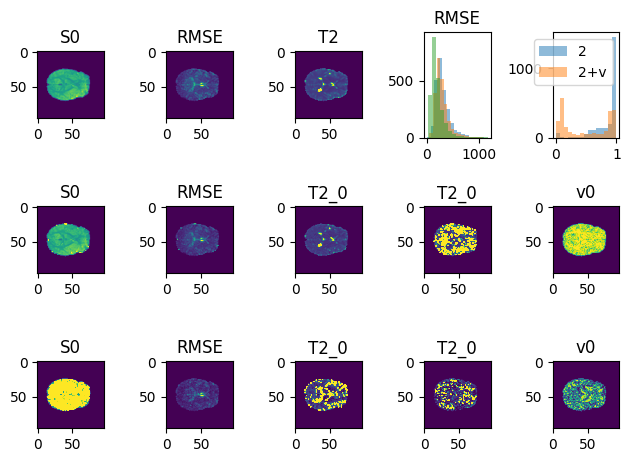

In [ ]:
fig, axs = plt.subplots(3,5)

vmax = [X_1[:,:,0].max(), 350]

# one compartment
axs[0,0].imshow(X_1[:,:,0], vmax=vmax[0])
axs[0,0].set_title('S0')
axs[0,2].imshow(X_1[:,:,1], vmax=vmax[1])
axs[0,2].set_title('T2')
axs[0,1].imshow(rmse_1, vmax=rmse_1.max()/2)
axs[0,1].set_title('RMSE')
rmse_bar = rmse_1.flatten()
axs[0,3].hist(rmse_bar[(rmse_bar > 0) * (rmse_bar < 1200)], bins=15, alpha=0.5, label='1')
axs[0,3].set_title('RMSE')

vmax = [X_1[:,:,0].max(), 350]
# 2 compartment
axs[1,0].imshow(X_2[:,:,0], vmax=vmax[0])
axs[1,0].set_title('S0')
axs[1,2].imshow(X_2[:,:,1], vmax=vmax[1])
axs[1,2].set_title('T2_0')
axs[1,3].imshow(X_2[:,:,2], vmax=vmax[1])
axs[1,3].set_title('T2_0')
axs[1,1].imshow(rmse_2, vmax=rmse_2.max()/2)
axs[1,1].set_title('RMSE')
axs[1,4].imshow(seg_data[:,:,slice_default,1:].max(axis=-1))
axs[1,4].set_title('v0')
rmse_bar = rmse_2.flatten()
axs[0,3].hist(rmse_bar[(rmse_bar > 0) * (rmse_bar < 1200)], bins=15, alpha=0.5, label='2')
seg_slice_flatten = seg_data[:,:,slice_default,1:].max(axis=-1).flatten()
axs[0,4].hist(seg_slice_flatten[seg_slice_flatten > 0], bins=15, alpha=0.5, label='2')

vmax = [X_1[:,:,0].max(), 350]
# 2 compartment
axs[2,0].imshow(X_3[:,:,0], vmax=vmax[0])
axs[2,0].set_title('S0')
axs[2,2].imshow(X_3[:,:,1], vmax=vmax[1])
axs[2,2].set_title('T2_0')
axs[2,3].imshow(X_3[:,:,2], vmax=vmax[1])
axs[2,3].set_title('T2_0')
axs[2,1].imshow(rmse_3, vmax=rmse_3.max()/2)
axs[2,1].set_title('RMSE')
axs[2,4].imshow(X_3[:,:,3])
axs[2,4].set_title('v0')
rmse_bar = rmse_3.flatten()
axs[0,3].hist(rmse_bar[(rmse_bar > 0) * (rmse_bar < 1200)], bins=15, alpha=0.5, label='2+v')
# axs[0,3].legend()
axs[0,4].hist(X_3[X_3[:,:,3] > 0 * X_3[:,:,3],3].flatten(), bins=15, alpha=0.5, label='2+v')
axs[0,4].legend()

fig.tight_layout()
fig.show()

In [ ]:
vox_i, vox_j = 40, 30
S0 = [X_1[vox_i, vox_j, 0], np.array(X_2[vox_i, vox_j, 0]), np.array(X_3[vox_i, vox_j, 0])]
T2 = [X_1[vox_i, vox_j, 1], np.array([X_2[vox_i, vox_j, 1], X_2[vox_i, vox_j, 2]]).reshape(1,2), np.array([X_3[vox_i, vox_j, 1], X_3[vox_i, vox_j, 2]]).reshape(1,2)]
v0 = seg_data[vox_i, vox_j, slice_default, 1:].max()
v = [1, np.array([v0, 1-v0]).reshape(1,2), np.array([X_3[vox_i, vox_j, 3], X_3[vox_i, vox_j, 4]]).reshape(1,2)]

signal_actual = mri_data[vox_i, vox_j, slice_default, :]
signal_1 = utils.model_one_compartment_voxel(T2=T2[0], S0=S0[0], TE=TE_times)
signal_2 = utils.model_multi_compartment(T2=T2[1], S0=S0[1], TE=TE_times, v=v[1])
signal_3 = utils.model_multi_compartment(T2=T2[2], S0=S0[2], TE=TE_times, v=v[2])

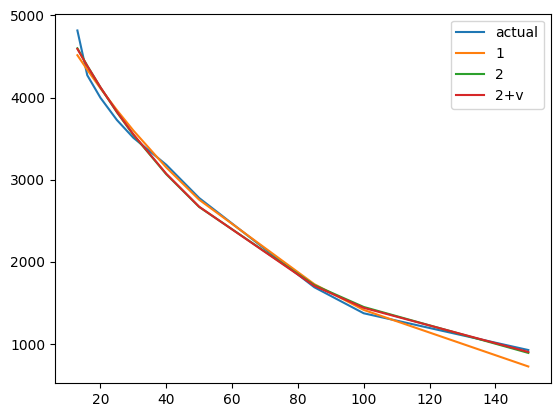

In [ ]:
plt.plot(TE_times, signal_actual, label='actual')
plt.plot(TE_times, signal_1, label='1')
plt.plot(TE_times, signal_2[0], label='2')
plt.plot(TE_times, signal_3[0], label='2+v')
plt.legend()
plt.show()

### Add noise to initial conditions to find the optimal solution

In [ ]:
roi_dict, roi_id_dict = dataloader.get_roi_dicts()

In [ ]:
def ecdf(data: NDArray):
    data = data.flatten()
    data.sort()
    x = data
    y = np.linspace(start=0, stop=1, num=data.shape[0])
    return x, y


def epdf(data: NDArray, bins=10):
    cdf_x, cdf_y = ecdf(data)
    n = cdf_x.shape[0]
    try: 
        x = np.linspace(start=cdf_x.min(), stop=cdf_x.max(), num=bins)
    except:
        x = np.zeros(1)
        y = np.zeros(1)
        return x, y        
    y = np.zeros(x.shape[0])
    for i, dx in enumerate(x):
        if i == 0:
            y[0] = 0
        else:
            y[i] = (cdf_x <= x[i]).sum() - (cdf_x <= x[i-1]).sum()
    y = y/n
    return x, y
            
    

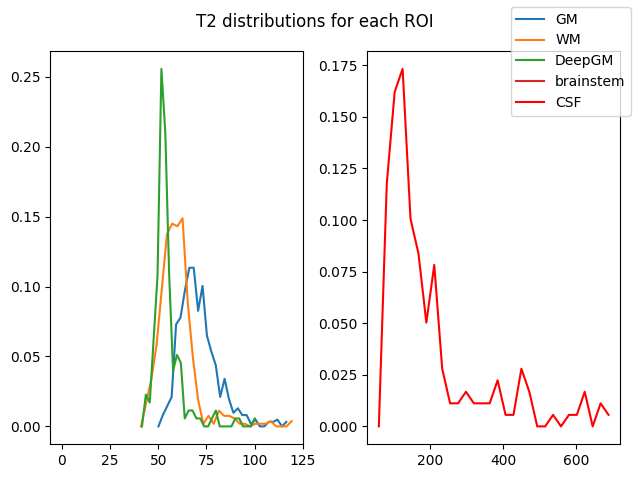

In [ ]:
T2=[]
thresh_default = 0.9
fig, axs = plt.subplots(1,2)

for seg_id in range(len(roi_dict)):
    T2.append(X_2[seg_data[:,:,slice_default, seg_id] > thresh_default, 1].flatten())

for roi_id in np.arange(len(roi_dict))[1:]:
    roi = roi_id_dict[roi_id]
    if roi == 'CSF':
        ax_id = 1
        hist_max = 700
        hist_min = 25
        col='r'
    else:
        ax_id = 0
        hist_max = 120
        hist_min = 25
    T2_seg = T2[roi_id]
    T2_seg = T2_seg[(T2_seg < hist_max) * (T2_seg > hist_min)]
    x, y = epdf(T2_seg, bins=30)
    if roi == 'CSF':
        axs[ax_id].plot(x, y, label=roi, color=col)
    else:
        axs[ax_id].plot(x, y, label=roi)        
fig.legend()
fig.suptitle('T2 distributions for each ROI')
fig.tight_layout()

In [ ]:
stats.describe(T2.flatten())

DescribeResult(nobs=9216, minmax=(0.0, 224386.6832147378), mean=72.34480653377658, variance=9707038.040849077, skewness=64.42737120527526, kurtosis=4291.907593957071)

In [ ]:
stats.mode(T2[0][T2[0]>0])

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_18048\3336686966.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(T2[0][T2[0]>0])


ModeResult(mode=array([2.63762623]), count=array([1]))

In [ ]:
a = np.arange(12).reshape(2,3,2)
for index in np.ndindex(a.shape[:-1]):
    print(index)
    print(a[index])

(0, 0)
[0 1]
(0, 1)
[2 3]
(0, 2)
[4 5]
(1, 0)
[6 7]
(1, 1)
[8 9]
(1, 2)
[10 11]


### one compartment setup

In [207]:
# def objective_one_compartment(x, signal, TE_times):
#     S0, T2 = x
#     vox_est = utils.model_one_compartment_voxel(T2, S0, TE_times)
#     SSD = utils.SSD(signal_actual=signal, signal_estimate=vox_est, dim=-1)
#     return SSD

# # Define the constraint function
# def constraint_one_compartment(x):
#     return 0

# # Define the bounds of the variables
# bounds = [(0, 15000), (20, 250)]
# problem_one_compartment = {'fun': objective_one_compartment, 'bounds': bounds}

In [7]:
problem_one_compartment = utils.create_problem_to_minimize(problem='one_compartment')
roi_id = 0
is_solve_for = seg_data[:,:,slice_default,roi_id] > thresh_default

x0 = np.array([5000, 50])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

signal = mri_data[:,:,slice_default,:]
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE]

S0, T2 = utils.minimize_given_problem(problem=problem_one_compartment, X0=X0, args_list=args, is_solve_for=is_solve_for)

NameError: name 'seg_data' is not defined

### 2 compartment setup

In [297]:
def objective_two_compartment(x, signal, TE_times, v):
    S0, T2_0, T2_1 = x
    S0 = np.array([S0])
    T2 = np.array([T2_0, T2_1]).reshape(1,2)
    v = v.reshape(1,2)
    vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
    SSD = utils.SSD(signal_actual=signal, signal_estimate=vox_est, dim=-1)
    return SSD

# Define the constraint function
def constraint_two_compartment(x):
    return 0

# Define the bounds of the variables
bounds = [(2000, 15000), (20, 200), (40,250)]
problem_two_compartment = {'fun': objective_two_compartment, 'bounds': bounds}

# Set the initial guess for the variables
x0 = [4000, 50, 50] # [S0, T2_0, T2_1]


In [136]:
roi_id = 0
is_solve_for = seg_data[:,:,slice_default,roi_id] > thresh_default

x0 = np.array([5000, 50, 50])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

v0 = seg_data[:,:,slice_default,1:].max(axis=-1)
v0 = np.where(v0 < 0.5, 0.5, v0)
v = np.stack([v0, 1-v0], axis=-1)

signal = mri_data[:,:,slice_default,:]
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE, v]

S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_solve_for=is_solve_for)

T2 = np.stack([T2_0, T2_1], axis=-1)

  0%|          | 0/9216 [00:00<?, ?it/s]c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\comp0118-group-project\utils_fc.py:137: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2
100%|##########| 9216/9216 [00:36<00:00, 250.12it/s]  


### 2+v compartment setup

In [161]:
def objective_two_v_compartment(x, signal, TE_times):
    S0, T2_0, T2_1, v0 = x
    S0 = np.array([S0])
    T2 = np.array([T2_0, T2_1]).reshape(1,2)
    v = np.array([v0, 1 - v0]).reshape(1,2)
    vox_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v).flatten()
    SSD = utils.SSD(signal_actual=signal, signal_estimate=vox_est, dim=-1)
    return SSD

# Define the constraint function
def constraint_two_v_compartment(x):
    return 0

# Define the bounds of the variables
bounds = [(2000, 15000), (20, 200), (40,250), (0, 1)]
problem_two_v_compartment = {'fun': objective_two_v_compartment, 'bounds': bounds}
# problem = {'fun': objective_two_compartment_optim_v, 'constraints': [{'type': 'eq', 'fun': constraint}], 'bounds': bounds}


roi_id = 0
is_solve_for = seg_data[:,:,slice_default,roi_id] > thresh_default

x0 = np.array([5000, 50, 50, 0.9])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

# v0 = seg_data[:,:,slice_default,1:].max(axis=-1)
# v0 = np.where(v0 < 0.5, 0.5, v0)
# v = np.stack([v0, 1-v0], axis=-1)

signal = mri_data[:,:,slice_default,:]
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE]

S0, T2_0, T2_1, v0 = utils.minimize_given_problem(problem=problem_two_v_compartment, X0=X0, args_list=args, is_solve_for=is_solve_for)

T2 = np.stack([T2_0, T2_1], axis=-1)
v = np.stack([v0, 1-v0], axis=-1)


100%|##########| 9216/9216 [01:26<00:00, 106.47it/s]  


c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\comp0118-group-project\utils_fc.py:137: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2


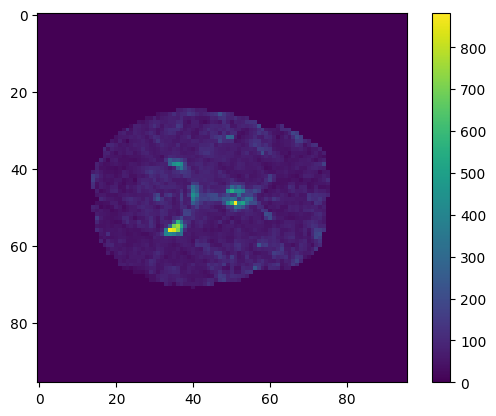

In [162]:
signal_est = utils.model_multi_compartment(T2, S0, TE_times, v)
rmse = utils.RMSE(signal, signal_est, dim=-1) * is_solve_for

plt.imshow(rmse)
plt.colorbar()

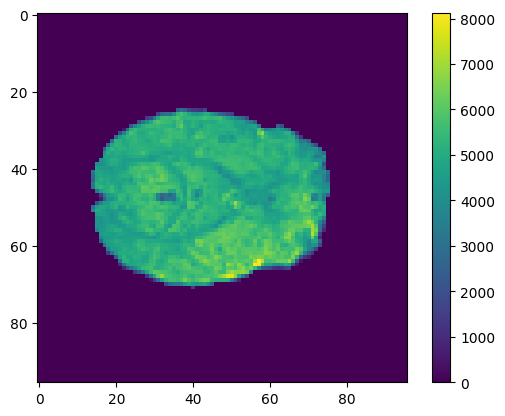

In [164]:
plt.imshow(S0)
plt.colorbar()

(array([6.903e+03, 2.500e+01, 3.300e+01, 6.000e+01, 7.100e+01, 5.330e+02,
        1.193e+03, 3.620e+02, 3.100e+01, 5.000e+00]),
 array([   0.        ,  812.81427871, 1625.62855742, 2438.44283613,
        3251.25711485, 4064.07139356, 4876.88567227, 5689.69995098,
        6502.51422969, 7315.3285084 , 8128.14278711]),
 <BarContainer object of 10 artists>)

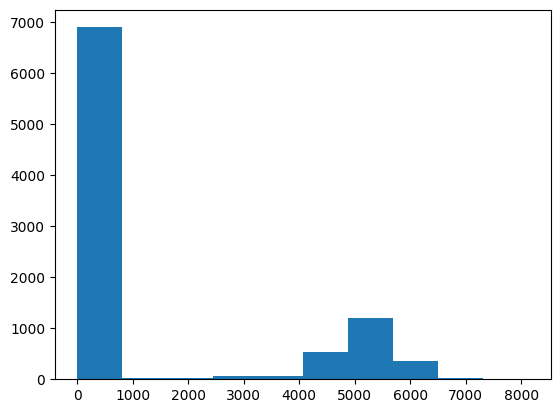

In [165]:
plt.hist(S0.flatten())

In [167]:
T2[:,:,1].flatten()[2532]

112.12505533496977

(array([1716.,   53.,   62.,  135.,  142.,  109.,   47.,   14.,    4.,
          39.]),
 array([ 20.,  28.,  36.,  44.,  52.,  60.,  68.,  76.,  84.,  92., 100.]),
 <BarContainer object of 10 artists>)

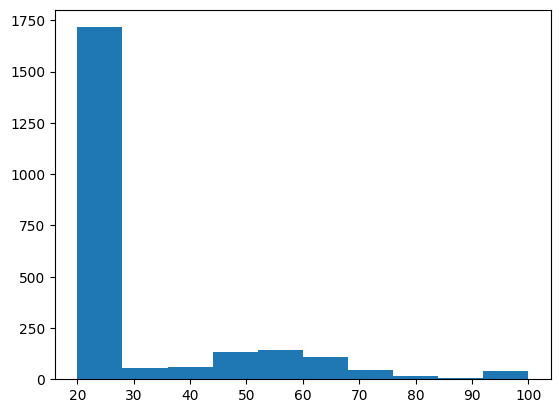

In [171]:
plt.hist(T2[seg_data[:,:,slice_default,0]==1,0].flatten())

(array([215., 864., 345., 157.,  96.,  68.,  75.,  60.,  75., 366.]),
 array([ 40.,  61.,  82., 103., 124., 145., 166., 187., 208., 229., 250.]),
 <BarContainer object of 10 artists>)

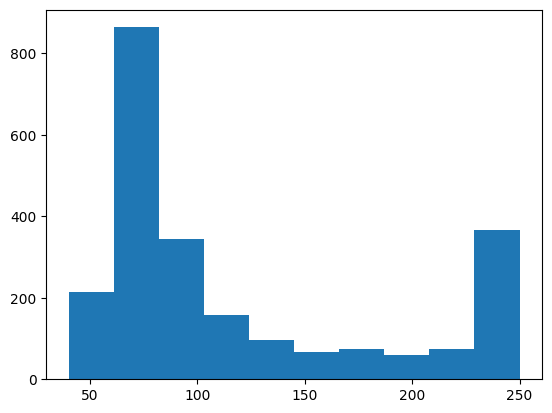

In [170]:
plt.hist(T2[seg_data[:,:,slice_default,0]==1,1].flatten())

In [172]:
(S0==5000).sum()

0

### should we repeat the fitting operation multiple times? - one compartment

In [307]:
nb_rand = 200
nb_repeat = 100
roi_id = 0
nb_total = (seg_data[:,:,:,roi_id] > thresh_default).sum()
rand_ids = np.random.random_integers(low=0, high=nb_total, size=nb_rand)
seg_data_flattened = seg_data.reshape(-1,seg_data.shape[-1])
mri_data_flattened = mri_data.reshape(-1,mri_data.shape[-1])

roi_data = mri_data_flattened[seg_data_flattened[:,roi_id] > thresh_default,:]
voxels = roi_data[rand_ids,:]

roi_seg_data_flattened = seg_data_flattened[seg_data_flattened[:,roi_id] > thresh_default,:]
roi_v0_data = roi_seg_data_flattened.max(axis=-1)
roi_v0_data = np.where(roi_v0_data < 0.5, 0.5, roi_v0_data)
voxels_v0 = roi_v0_data[rand_ids]
v = np.stack([voxels_v0, 1-voxels_v0], axis=-1)

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_18048\1252302906.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 63631 + 1) instead
  rand_ids = np.random.random_integers(low=0, high=nb_total, size=nb_rand)


In [284]:
solve_shape = voxels.shape[:-1]
is_solve_for = np.ones(shape=solve_shape)

x0 = np.array([5000, 50])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

signal = voxels
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE]

answers = []
for i in tqdm(range(nb_repeat), ascii=True):
    std = x0 / 5
    nb_args = x0.shape[0]
    X0_noise = np.random.randn(*solve_shape, nb_args)
    X0_noise = np.einsum('...a,a->...a', X0_noise, std)
    X0_noise = X0 + X0_noise
    S0, T2 = utils.minimize_given_problem(problem=problem_one_compartment, X0=X0_noise, args_list=args, is_solve_for=is_solve_for, is_print_progress=False)
    signal_est = utils.model_one_compartment(T2=T2, S0=S0, TE=TE_times)
    SSD = utils.SSD(signal_actual=voxels, signal_estimate=signal_est)
    answers.append([S0, T2, SSD])

100%|##########| 100/100 [02:40<00:00,  1.61s/it]


(array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <BarContainer object of 10 artists>)

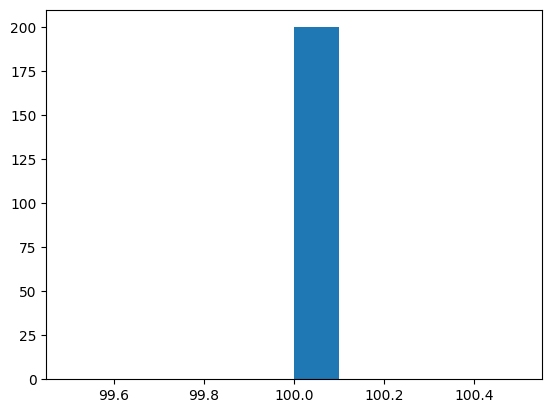

In [286]:
S0_list = []
T2_list = []
SSD_list = []

for i in range(nb_repeat):
    S0_list.append(answers[i][0])
    T2_list.append(answers[i][1])
    SSD_list.append(answers[i][2])
S0 = np.array(S0_list)
T2 = np.array(T2_list)
SSD = np.array(SSD_list)

SSD_min = SSD.min(axis=0)
SSD_min = np.tile(SSD_min, nb_repeat).reshape(nb_repeat,-1)

is_min = np.isclose(SSD, SSD_min, rtol=1)
nb_min = is_min.sum(axis=0)

plt.hist(nb_min)

### Should we repeat the fitting? 2 compartment

In [310]:
solve_shape = voxels.shape[:-1]
is_solve_for = np.ones(shape=solve_shape)

x0 = np.array([5000, 50, 60])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

signal = voxels
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE, v]

answers = []
for i in tqdm(range(nb_repeat), ascii=True):
    std = x0 / 5
    nb_args = x0.shape[0]
    X0_noise = np.random.randn(*solve_shape, nb_args)
    X0_noise = np.einsum('...a,a->...a', X0_noise, std)
    X0_noise = X0 + X0_noise
    S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0_noise, args_list=args, is_solve_for=is_solve_for, is_print_progress=False)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    signal_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v)
    SSD = utils.SSD(signal_actual=voxels, signal_estimate=signal_est)
    answers.append([S0, T2, SSD])

100%|##########| 100/100 [03:06<00:00,  1.86s/it]


(array([  0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.]),
 array([ 99.5,  99.6,  99.7,  99.8,  99.9, 100. , 100.1, 100.2, 100.3,
        100.4, 100.5]),
 <BarContainer object of 10 artists>)

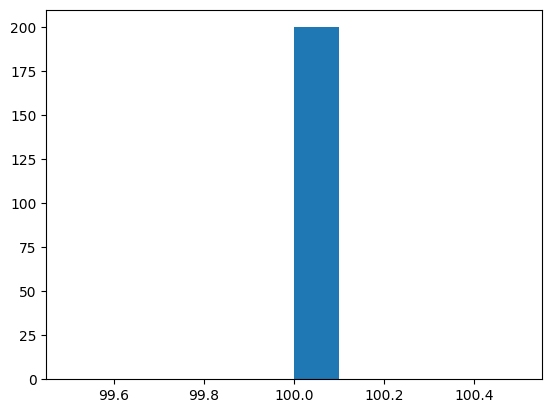

In [311]:
S0_list = []
T2_list = []
SSD_list = []

for i in range(nb_repeat):
    S0_list.append(answers[i][0])
    T2_list.append(answers[i][1])
    SSD_list.append(answers[i][2])
S0 = np.array(S0_list)
T2 = np.array(T2_list)
SSD = np.array(SSD_list)

SSD_min = SSD.min(axis=0)
SSD_min = np.tile(SSD_min, nb_repeat).reshape(nb_repeat,-1)

is_min = np.isclose(SSD, SSD_min, rtol=1)
nb_min = is_min.sum(axis=0)

plt.hist(nb_min)

### Should we repeat the fitting? 2 compartment + v

In [313]:
solve_shape = voxels.shape[:-1]
is_solve_for = np.ones(shape=solve_shape)

x0 = np.array([5000, 50, 60, 0.7])
X0 = np.einsum('...,i->...i', is_solve_for, x0)

signal = voxels
args_TE = np.einsum('...,i->...i', is_solve_for, TE_times)
args = [signal, args_TE]

answers = []
for i in tqdm(range(nb_repeat), ascii=True):
    std = x0 / 5
    nb_args = x0.shape[0]
    X0_noise = np.random.randn(*solve_shape, nb_args)
    X0_noise = np.einsum('...a,a->...a', X0_noise, std)
    X0_noise = X0 + X0_noise
    S0, T2_0, T2_1, v0 = utils.minimize_given_problem(problem=problem_two_v_compartment, X0=X0_noise, args_list=args, is_solve_for=is_solve_for, is_print_progress=False)
    T2 = np.stack([T2_0, T2_1], axis=-1)
    v = np.stack([v0, 1-v0], axis=-1)
    signal_est = utils.model_multi_compartment(T2=T2, S0=S0, TE=TE_times, v=v)
    SSD = utils.SSD(signal_actual=voxels, signal_estimate=signal_est)
    answers.append([S0, T2, SSD, v])

100%|##########| 100/100 [11:28<00:00,  6.88s/it]


(array([  2.,   0.,   1.,   2.,   2.,   8.,   7.,  17.,  13., 148.]),
 array([ 86. ,  87.4,  88.8,  90.2,  91.6,  93. ,  94.4,  95.8,  97.2,
         98.6, 100. ]),
 <BarContainer object of 10 artists>)

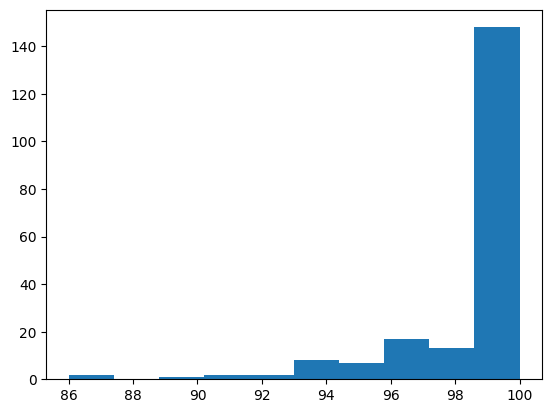

In [314]:
S0_list = []
T2_list = []
SSD_list = []
v_list=[]

for i in range(nb_repeat):
    S0_list.append(answers[i][0])
    T2_list.append(answers[i][1])
    SSD_list.append(answers[i][2])
    v_list.append(answers[i][3])
S0 = np.array(S0_list)
T2 = np.array(T2_list)
SSD = np.array(SSD_list)
v = np.array(v_list)

SSD_min = SSD.min(axis=0)
SSD_min = np.tile(SSD_min, nb_repeat).reshape(nb_repeat,-1)

is_min = np.isclose(SSD, SSD_min, rtol=1)
nb_min = is_min.sum(axis=0)

plt.hist(nb_min)

In [317]:
np.log(0.05) / np.log(0.14)

1.5236827651290796